In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats
from collections import namedtuple
import json
import importlib

import compare_rates
importlib.reload(compare_rates)

<module 'compare_rates' from '/Users/kelley/Projects/FamilySeqError/parameter_estimation/compare_rates.py'>

In [2]:
chroms = [str(i) for i in range(1, 23)]

gens = ['0/0', '0/1', '1/1']
obss = ['0/0', '0/1', '1/1', './.']

In [26]:
def process_datasets(datasets):
    for d in datasets:
        print(d)
        if not isinstance(d['family_genotype_dir'], list):
            d['family_genotype_dir'] = [d['family_genotype_dir']]
            d['param_file'] = [d['param_file']]
            
        for key in ['precision1', 'precision2', 'recall1', 'recall2']:
            d['%s_estimates' % key] = []
            d['%s_upper_bounds' % key] = []
        
        for famgen_dir, param_file in zip(d['family_genotype_dir'], d['param_file']):
        
            samples = compare_rates.pull_samples(famgen_dir, chroms)
            sample_indices = d['sample_filter'](samples)
            precision_recall = compare_rates.pull_precision_recall(samples, param_file) 
            
            # pull num missing
            with open(param_file, 'r') as f:
                params = json.load(f)

            family_size = np.zeros((len(samples.sample_ids),))
            family_size[:] = np.nan
            frac_nm = np.zeros((len(samples.sample_ids),))
            frac_nm[:] = np.nan
            frac_missing = np.zeros((len(samples.sample_ids),))
            frac_missing[:] = np.nan

            for i, (sample_id, family) in enumerate(zip(samples.sample_ids, samples.families)):
                key = '%s.%s' % (family, sample_id)
                if key in params:
                    family_size[i] = params[key]['family_size']
                    frac_nm[i] = params[key]['nonmendelian_count']/params[key]['total_count']
                    frac_missing[i] = params[key]['missing_count']/params[key]['total_count']
            family_size = family_size[sample_indices]
            frac_nm = frac_nm[sample_indices]
            frac_missing = frac_missing[sample_indices]
            
            print('num removed due to missing', np.sum(frac_missing>=0.1))
            print('num removed due to too many non-Mendelian sites', np.sum(frac_nm>=0.01))

            for key in ['precision1', 'precision2', 'recall1', 'recall2']:
                estimates = getattr(precision_recall, key)[sample_indices]
                upper_bounds = getattr(precision_recall, '%s_upper_bound' % key)[sample_indices]
                d['%s_estimates' % key].append(estimates[~np.isnan(estimates) & ~np.isnan(upper_bounds) & (frac_missing<0.1) & (frac_nm<0.01)])
                d['%s_upper_bounds' % key].append(upper_bounds[~np.isnan(estimates) & ~np.isnan(upper_bounds) & (frac_missing<0.1) & (frac_nm<0.01)])
            print(d['precision1_estimates'][-1].shape)
                
        for key in ['precision1', 'precision2', 'recall1', 'recall2']:
            d['%s_estimates' % key] = np.hstack(d['%s_estimates' % key])
            d['%s_upper_bounds' % key] = np.hstack(d['%s_upper_bounds' % key])
            print(d['%s_estimates' % key].shape, d['%s_upper_bounds' % key].shape)


# Set up plotting. 

In [27]:
def plot_precision_recall(filename, datasets, ylim=[0, 5], 
                          dotted=False, rotate_xlabels=False, legend_labels=None, legend_colors=None, figsize=(8, 6)):
    fig, subs = plt.subplots(2, 2, sharey=True, figsize=figsize)
    
    
    for k, gen in enumerate(['1', '2']):
        for l, attr in enumerate(['precision', 'recall']):
            error_estimates = [d[attr + gen + '_estimates'] for d in datasets]
            upper_bounds = [d[attr + gen + '_upper_bounds'] for d in datasets]
            
            upper_bound = [np.median(-np.log10(1-ub)) for ub in upper_bounds]
            #lower_bound = [np.min(-np.log10(1-remove_nans(getattr(dataset['precision_recall'], attr)[dataset['sample_indices']]))) for dataset in datasets]
            lower_bound = [0]*len(datasets)
            for j in range(len(datasets)):
                subs[l, k].fill([j+0.7, j+0.7, j+1.3, j+1.3], [lower_bound[j], upper_bound[j], upper_bound[j], lower_bound[j]],
                                lw=0, c='lightgray', zorder=-10)

            data = [-np.log10(1-np.clip(ee, None, ub)) for ee, ub in zip(error_estimates, upper_bounds)]
            print('n=', [d.shape[0] for d in data])
            parts = subs[l, k].violinplot(data, showmedians=True, showextrema=False, widths=0.8)


            if dotted:
                subs[l, k].plot(np.arange(1, 1+len(datasets)), 
                                [np.median(-np.log10(1-datasets[0][gen + attr + '_estimates']))]*len(datasets), 
                                color='black', linestyle='--')


            for pc, d in zip(parts['bodies'], datasets):
                pc.set_facecolor(d['color'])
                pc.set_edgecolor('black')
                pc.set_alpha(1)
            parts['cmedians'].set_edgecolor('black')
            parts['cmedians'].set_linewidth(2)
                
            subs[l, k].grid(True, axis='y', color='darkgray')
            subs[l, k].set_axisbelow(True)
            subs[l, k].set_ylim(ylim)

    # yticks only on leftmost panels
    subs[0, 0].set_yticks(np.arange(1, ylim[1]))
    subs[0, 0].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[l, k].get_yticks()], {'fontsize': 15})
    subs[0, 1].tick_params('y', length=0)
    subs[1, 0].set_yticks(np.arange(1, ylim[1]))
    subs[1, 0].set_yticklabels(['0.' + '9'*int(f) % f for f in subs[l, k].get_yticks()], {'fontsize': 15})
    subs[1, 1].tick_params('y', length=0)
    subs[0, 0].set_ylabel('Precision', {'fontsize':18})
    subs[1, 0].set_ylabel('Recall', {'fontsize':18})
    
    # xticks only on bottom panels
    subs[0, 0].set_xticks([])
    subs[0, 1].set_xticks([])
    subs[1, 0].set_xticks(np.arange(1, 1+len(datasets)))
    subs[1, 0].set_xticklabels([d['name'] for d in datasets], {'fontsize': 12 if rotate_xlabels else 15})
    subs[1, 1].set_xticks(np.arange(1, 1+len(datasets)))
    subs[1, 1].set_xticklabels([d['name'] for d in datasets], {'fontsize': 12 if rotate_xlabels else 15})
    if rotate_xlabels:
        for tick in subs[1, 0].get_xticklabels():
            tick.set_rotation(90)
        for tick in subs[1, 1].get_xticklabels():
            tick.set_rotation(90)
    
    # titles only on topmost panels
    subs[0, 0].set_title('Heterozygous Sites', {'fontsize': 18}, loc='left')
    subs[0, 1].set_title('Homozygous Alt. Sites', {'fontsize': 18}, loc='left')
    subs[1, 0].set_title(None)
    subs[1, 1].set_title(None)
    
    # legend
    if legend_labels is not None:
        entries = []
        for label, color in zip(legend_labels, legend_colors):
            entries.append(patches.Patch(color=color, label=label))
        subs[1, 1].legend(handles=entries, loc='lower center', ncol=3,
                                    bbox_to_anchor=(0, -0.3), borderaxespad=0., fontsize=15, frameon=False)
    
    
    fig.subplots_adjust(wspace=0.0, hspace=0.0, top=0.9, bottom=0.3 if rotate_xlabels else 0.2)
    #plt.show()
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()

# Compare platforms

In [28]:
ihart_wgs_samples = compare_rates.pull_samples('../../DATA/ihart.ms2/family_genotype_counts', chroms)
with open('../../FamilySeqError/params/ihart.ms2_params.json', 'r') as f:
    params = json.load(f)

    family_size = np.zeros((len(ihart_wgs_samples.sample_ids),))
    family_size[:] = np.nan
    num_nm = np.zeros((len(ihart_wgs_samples.sample_ids),))
    num_nm[:] = np.nan
    num_missing = np.zeros((len(ihart_wgs_samples.sample_ids),))
    num_missing[:] = np.nan
                
    for i, (sample_id, family) in enumerate(zip(ihart_wgs_samples.sample_ids, ihart_wgs_samples.families)):
        key = '%s.%s' % (family, sample_id)
        if key in params:
            family_size[i] = params[key]['family_size']
            num_nm[i] = params[key]['nonmendelian_count']/params[key]['total_count']
            num_missing[i] = params[key]['missing_count']/params[key]['total_count']

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


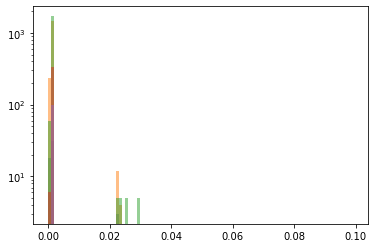

In [29]:
#bins=np.arange(4, 7, 0.1)
bins = np.arange(0, 0.1, 0.001)
plt.hist(num_nm[family_size==3], alpha=0.5, bins=bins, log=True)
plt.hist(num_nm[family_size==4], alpha=0.5, bins=bins, log=True)
plt.hist(num_nm[family_size==5], alpha=0.5, bins=bins, log=True)
plt.hist(num_nm[family_size==6], alpha=0.5, bins=bins, log=True)
plt.hist(num_nm[family_size>6], alpha=0.5, bins=bins, log=True)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


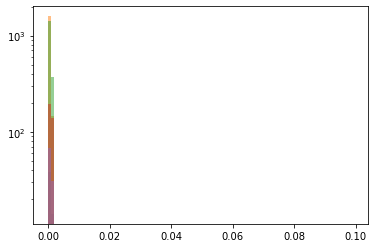

In [30]:
#bins=np.arange(4, 7, 0.1)
bins = np.arange(0, 0.1, 0.001)
plt.hist(num_missing[family_size==3], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size==4], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size==5], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size==6], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size>6], alpha=0.5, bins=bins, log=True)
plt.show()

//anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 4.001e+03]),
 array([-1.93027079e+04, -1.73725371e+04, -1.54423663e+04, -1.35121955e+04,
        -1.15820247e+04, -9.65185394e+03, -7.72168315e+03, -5.79151236e+03,
        -3.86134158e+03, -1.93117079e+03, -1.00000000e+00]),
 <a list of 10 Patch objects>)

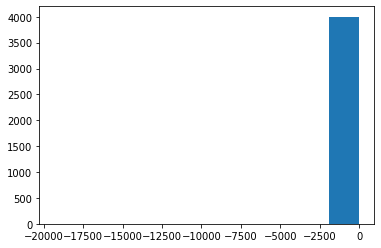

In [31]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=2)
clf.fit_predict(num_nm[~np.isnan(num_nm), np.newaxis])

plt.hist(clf.negative_outlier_factor_)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater


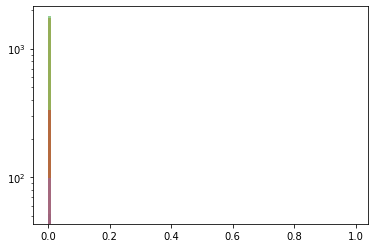

In [32]:
bins=np.arange(0, 1, 0.01)
plt.hist(num_missing[family_size==3], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size==4], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size==5], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size==6], alpha=0.5, bins=bins, log=True)
plt.hist(num_missing[family_size>6], alpha=0.5, bins=bins, log=True)
plt.show()

In [33]:
print(num_missing)

[0.00133362 0.00110575 0.00100625 ... 0.00069345 0.00064177 0.00052542]


In [34]:
ihart_is_ok_sample = set()
with open('../../PhasingFamilies/data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] == 'Passed_QC_analysis_ready':
            ihart_is_ok_sample.add(pieces[2])


In [35]:
ihart_wgs_samples = compare_rates.pull_samples('../../DATA/ihart.ms2/family_genotype_counts', chroms)
ihart_chip_samples = compare_rates.pull_samples('../../DATA/ihart.chip/family_genotype_counts', chroms)
ihart_chip_num_sites = compare_rates.pull_num_sites(ihart_chip_samples, '../../FamilySeqError/params/ihart.chip_params.json')

datasets_of_interest = [
    {'name': 'ihart',
     'color': '#4db6ac',
     'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.ms2_params.json',
     'sample_filter': lambda x: x.is_child & np.array([x in ihart_is_ok_sample for x in ihart_wgs_samples.sample_ids])
    },
    {'name': 'ssc',
     'color': '#4db6ac',
     'family_genotype_dir': ['../../DATA/ssc.hg38/family_genotype_counts/phase1-1',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-2',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-3',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-4',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-5',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase1-7',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase3_2',
                             '../../DATA/ssc.hg38/family_genotype_counts/phase4',
                             '../../DATA/ssc.hg38/family_genotype_counts/pilot'
                            ],
     'param_file': ['../../FamilySeqError/params/ssc.hg38_phase1-1_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-2_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-3_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-4_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-5_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase1-7_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_B01_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase2_Replacements_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_1_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_1_B02_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase3_2_params.json',
                   '../../FamilySeqError/params/ssc.hg38_phase4_params.json',
                   '../../FamilySeqError/params/ssc.hg38_pilot_params.json'
                   ],
     'sample_filter': lambda x: x.is_child
    },
    {'name': 'spark',
     'color': '#ef6c00',
     'family_genotype_dir': '../../DATA/spark.exome/family_genotype_counts/EX',
     'param_file': '../../FamilySeqError/params/spark.exome_EX_params.json',
     'sample_filter': lambda x: x.is_child
    },
    {'name': 'ihart',
     'color': '#ce93d8',
     'family_genotype_dir': '../../DATA/ihart.chip/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/ihart.chip_params.json',
     'sample_filter': lambda x: x.is_child & (np.array(ihart_chip_num_sites) > 300000)
    },
    {'name': 'spark',
     'color': '#ce93d8',
     'family_genotype_dir': '../../DATA/spark/family_genotype_counts',
     'param_file': '../../FamilySeqError/params/spark_params.json',
     'sample_filter': lambda x: x.is_child
    }
]


process_datasets(datasets_of_interest)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
{'name': 'ihart', 'color': '#4db6ac', 'family_genotype_dir': '../../DATA/ihart.ms2/family_genotype_counts', 'param_file': '../../FamilySeqError/params/ihart.ms2_params.json', 'sample_filter': <function <lambda> at 0x1a211a5048>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 3 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in greater_equal
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in greater_equal
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: invalid value encountered in less
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in less


num removed due to missing 0
num removed due to too many non-Mendelian sites 14
(2224,)
(2224,) (2224,)
(2224,) (2224,)
(2224,) (2224,)
(2224,) (2224,)
{'name': 'ssc', 'color': '#4db6ac', 'family_genotype_dir': ['../../DATA/ssc.hg38/family_genotype_counts/phase1-1', '../../DATA/ssc.hg38/family_genotype_counts/phase1-2', '../../DATA/ssc.hg38/family_genotype_counts/phase1-3', '../../DATA/ssc.hg38/family_genotype_counts/phase1-4', '../../DATA/ssc.hg38/family_genotype_counts/phase1-5', '../../DATA/ssc.hg38/family_genotype_counts/phase1-7', '../../DATA/ssc.hg38/family_genotype_counts/phase2_B01', '../../DATA/ssc.hg38/family_genotype_counts/phase2', '../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements', '../../DATA/ssc.hg38/family_genotype_counts/phase3_1', '../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02', '../../DATA/ssc.hg38/family_genotype_counts/phase3_2', '../../DATA/ssc.hg38/family_genotype_counts/phase4', '../../DATA/ssc.hg38/family_genotype_counts/pilot'], 'param_

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in greater


num removed due to missing 0
num removed due to too many non-Mendelian sites 112
(660,)
(660,) (660,)
(660,) (660,)
(660,) (660,)
(660,) (660,)
{'name': 'spark', 'color': '#ce93d8', 'family_genotype_dir': '../../DATA/spark/family_genotype_counts', 'param_file': '../../FamilySeqError/params/spark_params.json', 'sample_filter': <function <lambda> at 0x10c072d08>}
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
num removed due to missing 18
num removed due to too many non-Mendelian sites 5576
(1157,)
(1157,) (1157,)
(1157,) (1157,)
(1157,) (1157,)
(1157,) (1157,)


n= [2224, 3998, 9599, 660, 1157]
n= [2224, 3998, 9599, 660, 1157]
n= [2224, 3998, 9599, 660, 1157]
n= [2224, 3998, 9599, 660, 1157]


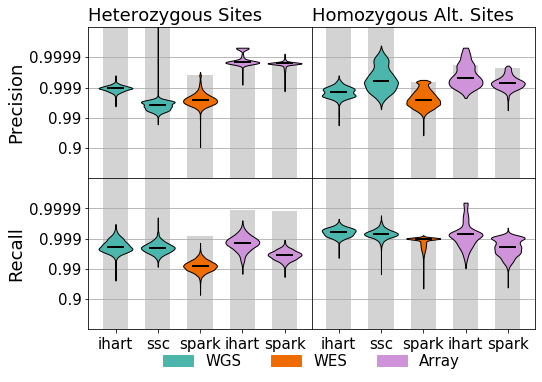

In [37]:
plot_precision_recall('../plots/sequencing_method.eps',
                      datasets_of_interest,
                      legend_labels=['WGS', 'WES', 'Array'], legend_colors=['#4db6ac', '#ef6c00', '#ce93d8'],
                     )

In [49]:
#ihart_samples = compare_rates.pull_samples('../../DATA/ihart/family_genotype_counts', chroms)
#ihart_samples = compare_rates.pull_samples('../../PhasingFamilies/split_gen_ihart_quads', chroms)
#ihart_old_samples = compare_rates.pull_samples('../../DATA/ihart/family_genotype_counts/CEN', chroms)
#ihart32_samples = compare_rates.pull_samples('../../PhasingFamilies/split_gen_ihart3.2', chroms)

#ssc_samples = compare_rates.pull_samples('../../PhasingFamilies/split_gen_ssc', chroms, dot_in_name=True)

spark_exome_samples = compare_rates.pull_samples('../../DATA/spark.exome/family_genotype_counts', chroms)
spark_samples = compare_rates.pull_samples('../../DATA/spark/family_genotype_counts', chroms)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
13249


In [19]:
#ssc_phase1_1_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase1-1_HCR', chroms)
#ssc_phase1_2_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase1-2_HCR', chroms)
#ssc_phase1_3_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase1-3_HCR', chroms)
#ssc_phase1_4_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase1-4_HCR', chroms)
#ssc_phase1_5_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase1-5_HCR', chroms)
#ssc_phase1_7_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase1-7_HCR', chroms)
#
#ssc_phase2_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase2_HCR', chroms)
#ssc_phase2_B01_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase2_B01_HCR', chroms)
#ssc_phase2_Replacements_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase2_Replacements_HCR', chroms)
#
#ssc_phase3_1_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase3_1_HCR', chroms)
#ssc_phase3_1_B02_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase3_1_B02_HCR', chroms)
#ssc_phase3_2_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase3_2_HCR', chroms)
#
#ssc_phase4_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/phase4_HCR', chroms)
#ssc_pilot_samples = compare_rates.pull_samples('../../DATA/ssc.hg38/family_genotype_counts/pilot_HCR', chroms)
#

In [20]:
#mssng_samples = compare_rates.pull_samples('../../DATA/mssng/family_genotype_counts/HCR_quads', chroms)


In [65]:
print(spark_samples.sample_ids[:10])

['SP0000014', 'SP0000015', 'SP0000027', 'SP0000034', 'SP0000051', 'SP0000063', 'SP0000111', 'SP0000145', 'SP0000226', 'SP0000241']


In [67]:
#ihart_error_rates = compare_rates.pull_error_rates(ihart_samples, '../../PhasingFamilies/params/ihart_params.json', gens, obss)
#ihart_LCR_error_rates = compare_rates.pull_error_rates(ihart_samples, '../../PhasingFamilies/params/ihart_LCR_params.json', gens, obss)
#ihart_HCR_error_rates = compare_rates.pull_error_rates(ihart_samples, '../../PhasingFamilies/params/ihart_HCR_params.json', gens, obss)
#ihart_EX_error_rates = compare_rates.pull_error_rates(ihart_samples, '../../PhasingFamilies/params/ihart_EX_params.json', gens, obss)
#ihart32_error_rates = compare_rates.pull_error_rates(ihart32_samples, '../../PhasingFamilies/params/ihart3.2_params.json', gens, obss)
#ihart_chip_error_rates = compare_rates.pull_error_rates(ihart_samples, '../../PhasingFamilies/params/ihart_chip_params.json', gens, obss)

#spark_exome_EX_error_rates = compare_rates.pull_error_rates(spark_exome_samples, '../../FamilySeqError/params/spark.exome_params.json', gens, obss)
spark_error_rates = compare_rates.pull_error_rates(spark_samples, '../../FamilySeqError/params/spark_params.json', gens, obss)


In [68]:
#ssc_phase1_1_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_1_samples, '../params/ssc.hg38_phase1-1_HCR_params.json')
#ssc_phase1_1_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_1_samples, '../params/ssc.hg38_phase1-1_LCR_params.json')
#ssc_phase1_2_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_2_samples, '../params/ssc.hg38_phase1-2_HCR_params.json')
#ssc_phase1_2_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_2_samples, '../params/ssc.hg38_phase1-2_LCR_params.json')
#ssc_phase1_3_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_3_samples, '../params/ssc.hg38_phase1-3_HCR_params.json')
#ssc_phase1_3_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_3_samples, '../params/ssc.hg38_phase1-3_LCR_params.json')
#ssc_phase1_4_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_4_samples, '../params/ssc.hg38_phase1-4_HCR_params.json')
#ssc_phase1_4_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_4_samples, '../params/ssc.hg38_phase1-4_LCR_params.json')
#ssc_phase1_5_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_5_samples, '../params/ssc.hg38_phase1-5_HCR_params.json')
#ssc_phase1_5_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_5_samples, '../params/ssc.hg38_phase1-5_LCR_params.json')
#ssc_phase1_7_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_7_samples, '../params/ssc.hg38_phase1-7_HCR_params.json')
#ssc_phase1_7_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase1_7_samples, '../params/ssc.hg38_phase1-7_LCR_params.json')
#
#ssc_phase2_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase2_samples, '../params/ssc.hg38_phase2_HCR_params.json')
#ssc_phase2_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase2_samples, '../params/ssc.hg38_phase2_LCR_params.json')
#ssc_phase2_B01_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase2_B01_samples, '../params/ssc.hg38_phase2_B01_HCR_params.json')
#ssc_phase2_B01_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase2_B01_samples, '../params/ssc.hg38_phase2_B01_LCR_params.json')
#ssc_phase2_Replacements_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase2_Replacements_samples, '../params/ssc.hg38_phase2_Replacements_HCR_params.json')
#ssc_phase2_Replacements_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase2_Replacements_samples, '../params/ssc.hg38_phase2_Replacements_LCR_params.json')
#
#ssc_phase3_1_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase3_1_samples, '../params/ssc.hg38_phase3_1_HCR_params.json')
#ssc_phase3_1_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase3_1_samples, '../params/ssc.hg38_phase3_1_LCR_params.json')
#ssc_phase3_1_B02_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase3_1_B02_samples, '../params/ssc.hg38_phase3_1_B02_HCR_params.json')
#ssc_phase3_1_B02_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase3_1_B02_samples, '../params/ssc.hg38_phase3_1_B02_LCR_params.json')
#ssc_phase3_2_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase3_2_samples, '../params/ssc.hg38_phase3_2_HCR_params.json')
#ssc_phase3_2_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase3_2_samples, '../params/ssc.hg38_phase3_2_LCR_params.json')
#
#ssc_phase4_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase4_samples, '../params/ssc.hg38_phase4_HCR_params.json')
#ssc_phase4_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_phase4_samples, '../params/ssc.hg38_phase4_LCR_params.json')
#ssc_pilot_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_pilot_samples, '../params/ssc.hg38_pilot_HCR_params.json')
#ssc_pilot_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_pilot_samples, '../params/ssc.hg38_pilot_LCR_params.json')



In [70]:
ihart_is_ok_sample = set()
with open('../../PhasingFamilies/data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if pieces[0] == 'Passed_QC_analysis_ready':
            ihart_is_ok_sample.add(pieces[2])

In [71]:
#ihart_chip_num_sites = compare_rates.pull_num_sites(ihart_samples, '../../PhasingFamilies/params/ihart_chip_params.json')

In [72]:
#ihart_chip_is_ok_sample = ihart_is_ok_sample & set([x for x, n in zip(ihart_samples.sample_ids, ihart_chip_num_sites) if n>300000])
#plt.hist(ihart_chip_num_sites)

In [73]:
#ihart_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_params.json')
#ihart_LCR_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_LCR_params.json')
#ihart_HCR_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_HCR_params.json')
#ihart_EX_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_EX_params.json')
#ihart32_precision_recall = compare_rates.pull_precision_recall(ihart32_samples, '../../PhasingFamilies/params/ihart3.2_params.json')
#ihart34_precision_recall = compare_rates.pull_precision_recall(ihart32_samples, '../../PhasingFamilies/params/ihart_params.json')

#ihart_CEN_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../params/ihart_CEN_params.json')
#ihart_TEL_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../params/ihart_TEL_params.json')

spark_exome_EX_precision_recall = compare_rates.pull_precision_recall(spark_exome_samples, '../../FamilySeqError/params/spark.exome_quads_params.json')

spark_precision_recall = compare_rates.pull_precision_recall(spark_samples, '../../FamilySeqError/params/spark_quads_params.json')



In [74]:
#ihart_chip_GWAS_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_chip_GWAS_params.json')


In [75]:
#ssc_precision_recall = compare_rates.pull_precision_recall(ssc_samples, '../../PhasingFamilies/params/ssc_params.json')
#ssc_LCR_precision_recall = compare_rates.pull_precision_recall(ssc_samples, '../../PhasingFamilies/params/ssc_LCR_params.json')
#ssc_HCR_precision_recall = compare_rates.pull_precision_recall(ssc_samples, '../../PhasingFamilies/params/ssc_HCR_params.json')
#ssc_EX_precision_recall = compare_rates.pull_precision_recall(ssc_samples, '../../PhasingFamilies/params/ssc_EX_params.json')
#ssc_GWAS_precision_recall = compare_rates.pull_precision_recall(ssc_samples, '../../PhasingFamilies/params/ssc_GWAS_params.json')


In [76]:
#ihart_chip_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_chip_params.json')
#ihart_chip_GWAS_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_chip_GWAS_params.json')


In [77]:
#ihart_GWAS_precision_recall = compare_rates.pull_precision_recall(ihart_samples, '../../PhasingFamilies/params/ihart_GWAS_params.json')
#spark_exome_GWAS_precision_recall = compare_rates.pull_precision_recall(spark_exome_samples, '../../PhasingFamilies/params/spark_exome_GWAS_params.json')
#spark_GWAS_precision_recall = compare_rates.pull_precision_recall(spark_samples, '../../PhasingFamilies/params/spark_GWAS_params.json')


In [78]:
#mssng_HCR_precision_recall = compare_rates.pull_precision_recall(mssng_samples, '../params/mssng_HCR_params.json')
#mssng_LCR_precision_recall = compare_rates.pull_precision_recall(mssng_samples, '../params/mssng_LCR_params.json')


# SSC.hg38

In [81]:
#plot_precision_recall(None,
#                      [ssc_phase1_1_HCR_precision_recall, ssc_phase1_2_HCR_precision_recall, ssc_phase1_3_HCR_precision_recall, ssc_phase1_4_HCR_precision_recall, ssc_phase1_5_HCR_precision_recall, ssc_phase1_7_HCR_precision_recall,
#                      ssc_phase1_1_LCR_precision_recall, ssc_phase1_2_LCR_precision_recall, ssc_phase1_3_LCR_precision_recall, ssc_phase1_4_LCR_precision_recall, ssc_phase1_5_LCR_precision_recall, ssc_phase1_7_LCR_precision_recall],
#                      [ssc_phase1_1_samples.is_child, ssc_phase1_2_samples.is_child, ssc_phase1_3_samples.is_child, ssc_phase1_4_samples.is_child, ssc_phase1_5_samples.is_child, ssc_phase1_7_samples.is_child,
#                      ssc_phase1_1_samples.is_child, ssc_phase1_2_samples.is_child, ssc_phase1_3_samples.is_child, ssc_phase1_4_samples.is_child, ssc_phase1_5_samples.is_child, ssc_phase1_7_samples.is_child],
#                      '1',
#                      ['phase1-1\nHCR', 'phase1-2\nHCR', 'phase1-3\nHCR', 'phase1-4\nHCR', 'phase1-5\nHCR', 'phase1-7\nHCR',
#                      'phase1-1\nLCR', 'phase1-2\nLCR', 'phase1-3\nLCR', 'phase1-4\nLCR', 'phase1-5\nLCR', 'phase1-7\nLCR'],                      ['#cedd38']*6 + ['#009668']*6,
#                      legend_labels=['WGS'], legend_colors=['#4db6ac'], rotate_xlabels=True,
#                      figsize=(15, 5)
#                     )

#plot_precision_recall(None,
#                      [ssc_phase1_1_HCR_precision_recall, ssc_phase1_2_HCR_precision_recall, ssc_phase1_3_HCR_precision_recall, ssc_phase1_4_HCR_precision_recall, ssc_phase1_5_HCR_precision_recall, ssc_phase1_7_HCR_precision_recall,
#                      ssc_phase1_1_LCR_precision_recall, ssc_phase1_2_LCR_precision_recall, ssc_phase1_3_LCR_precision_recall, ssc_phase1_4_LCR_precision_recall, ssc_phase1_5_LCR_precision_recall, ssc_phase1_7_LCR_precision_recall],
#                      [ssc_phase1_1_samples.is_child, ssc_phase1_2_samples.is_child, ssc_phase1_3_samples.is_child, ssc_phase1_4_samples.is_child, ssc_phase1_5_samples.is_child, ssc_phase1_7_samples.is_child,
#                      ssc_phase1_1_samples.is_child, ssc_phase1_2_samples.is_child, ssc_phase1_3_samples.is_child, ssc_phase1_4_samples.is_child, ssc_phase1_5_samples.is_child, ssc_phase1_7_samples.is_child],
#                      '2',
#                      ['phase1-1\nHCR', 'phase1-2\nHCR', 'phase1-3\nHCR', 'phase1-4\nHCR', 'phase1-5\nHCR', 'phase1-7\nHCR',
#                      'phase1-1\nLCR', 'phase1-2\nLCR', 'phase1-3\nLCR', 'phase1-4\nLCR', 'phase1-5\nLCR', 'phase1-7\nLCR'],
#                      ['#cedd38']*6 + ['#009668']*6,
#                      legend_labels=['WGS'], legend_colors=['#4db6ac'], rotate_xlabels=True,
#                      figsize=(15, 5)
#                     )

In [82]:
#plot_precision_recall(None,
#                      [ssc_phase2_HCR_precision_recall, ssc_phase2_B01_HCR_precision_recall, ssc_phase2_Replacements_HCR_precision_recall, ssc_phase3_1_HCR_precision_recall, ssc_phase3_1_B02_HCR_precision_recall, ssc_phase3_2_HCR_precision_recall, ssc_phase4_HCR_precision_recall, ssc_pilot_HCR_precision_recall,
#                      ssc_phase2_LCR_precision_recall, ssc_phase2_B01_LCR_precision_recall, ssc_phase2_Replacements_LCR_precision_recall, ssc_phase3_1_LCR_precision_recall, ssc_phase3_1_B02_LCR_precision_recall, ssc_phase3_2_LCR_precision_recall, ssc_phase4_LCR_precision_recall, ssc_pilot_LCR_precision_recall],
#                      [ssc_phase2_samples.is_child, ssc_phase2_B01_samples.is_child, ssc_phase2_Replacements_samples.is_child, ssc_phase3_1_samples.is_child, ssc_phase3_1_B02_samples.is_child, ssc_phase3_2_samples.is_child, ssc_phase4_samples.is_child, ssc_pilot_samples.is_child,
#                      ssc_phase2_samples.is_child, ssc_phase2_B01_samples.is_child, ssc_phase2_Replacements_samples.is_child, ssc_phase3_1_samples.is_child, ssc_phase3_1_B02_samples.is_child, ssc_phase3_2_samples.is_child, ssc_phase4_samples.is_child, ssc_pilot_samples.is_child],
#                      '1',
#                      ['phase2\nHCR', 'phase2_B01\nHCR', 'phase2_Replacements\nHCR', 'phase3_1\nHCR', 'phase3_1_B02\nHCR', 'phase3_2\nHCR', 'phase4\nHCR', 'pilot\nHCR',
#                      'phase2\nLCR', 'phase2_B01\nLCR', 'phase2_Replacements\nLCR', 'phase3_1\nLCR', 'phase3_1_B02\nLCR', 'phase3_2\nLCR', 'phase4\nLCR', 'pilot\nLCR'],
#                      ['#cedd38']*8 + ['#009668']*8,
#                      legend_labels=['WGS'], legend_colors=['#4db6ac'], rotate_xlabels=True,
#                      figsize=(15, 5)
#                     )

#plot_precision_recall(None,
#                      [ssc_phase2_HCR_precision_recall, ssc_phase2_B01_HCR_precision_recall, ssc_phase2_Replacements_HCR_precision_recall, ssc_phase3_1_HCR_precision_recall, ssc_phase3_1_B02_HCR_precision_recall, ssc_phase3_2_HCR_precision_recall, ssc_phase4_HCR_precision_recall, ssc_pilot_HCR_precision_recall,
#                      ssc_phase2_LCR_precision_recall, ssc_phase2_B01_LCR_precision_recall, ssc_phase2_Replacements_LCR_precision_recall, ssc_phase3_1_LCR_precision_recall, ssc_phase3_1_B02_LCR_precision_recall, ssc_phase3_2_LCR_precision_recall, ssc_phase4_LCR_precision_recall, ssc_pilot_LCR_precision_recall],
#                      [ssc_phase2_samples.is_child, ssc_phase2_B01_samples.is_child, ssc_phase2_Replacements_samples.is_child, ssc_phase3_1_samples.is_child, ssc_phase3_1_B02_samples.is_child, ssc_phase3_2_samples.is_child, ssc_phase4_samples.is_child, ssc_pilot_samples.is_child,
#                      ssc_phase2_samples.is_child, ssc_phase2_B01_samples.is_child, ssc_phase2_Replacements_samples.is_child, ssc_phase3_1_samples.is_child, ssc_phase3_1_B02_samples.is_child, ssc_phase3_2_samples.is_child, ssc_phase4_samples.is_child, ssc_pilot_samples.is_child],
#                      '2',
#                      ['phase2\nHCR', 'phase2_B01\nHCR', 'phase2_Replacements\nHCR', 'phase3_1\nHCR', 'phase3_1_B02\nHCR', 'phase3_2\nHCR', 'phase4\nHCR', 'pilot\nHCR',
#                      'phase2\nLCR', 'phase2_B01\nLCR', 'phase2_Replacements\nLCR', 'phase3_1\nLCR', 'phase3_1_B02\nLCR', 'phase3_2\nLCR', 'phase4\nLCR', 'pilot\nLCR'],
#                      ['#cedd38']*8 + ['#009668']*8,
#                      legend_labels=['WGS'], legend_colors=['#4db6ac'], rotate_xlabels=True,
#                      figsize=(15, 5)
#                     )

# WGS at GWAS hits vs microarray.

n= [0, 1037, 0, 0]


ValueError: zero-size array to reduction operation minimum which has no identity

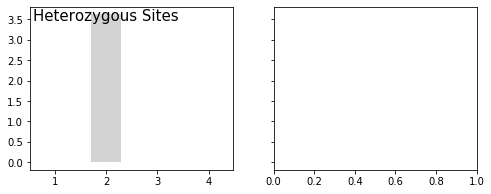

In [60]:
plot_precision_recall('../plots/gwas_het.eps',
                      [ihart_GWAS_precision_recall, ssc_GWAS_precision_recall, ihart_chip_precision_recall, spark_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]),
                      ssc_samples.is_child, 
                       ihart_samples.is_child & np.array([x in ihart_chip_is_ok_sample for x in ihart_samples.sample_ids]),
                       spark_samples.is_child],
                      '1',
                      ['ihart', 'ssc', 'ihart', 'spark'],
                      ['#4db6ac', '#4db6ac', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS at GWAS hits', 'Array'], legend_colors=['#4db6ac', '#ce93d8']
                     #ylim=[1.5, 4.5]
                     )

plot_precision_recall('../plots/gwas_homalt.eps',
                      [ihart_GWAS_precision_recall, ssc_GWAS_precision_recall, ihart_chip_precision_recall, spark_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]),
                      ssc_samples.is_child, 
                       ihart_samples.is_child & np.array([x in ihart_chip_is_ok_sample for x in ihart_samples.sample_ids]),
                       spark_samples.is_child],
                      '2',
                      ['ihart', 'ssc', 'ihart', 'spark'],
                      ['#4db6ac', '#4db6ac', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS at GWAS hits', 'Array'], legend_colors=['#4db6ac', '#ce93d8']
                     #ylim=[1.5, 4.5]
                     )

# Low complexity vs high complexity regions.

ValueError: zero-size array to reduction operation minimum which has no identity

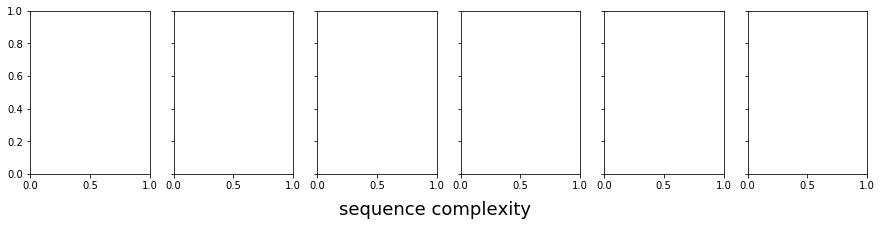

In [61]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#cedd38', '#009668']

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                      #('0/0', './.'), ('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('sequence complexity', y=0, fontsize=18)

for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    error_rates1 = -ihart_LCR_error_rates[:, g_index, o_index]
    error_rates1 = error_rates1[ihart_samples.is_child & ~np.isnan(error_rates1)]
    
    error_rates4 = -ihart_HCR_error_rates[:, g_index, o_index]
    error_rates4 = error_rates4[ihart_samples.is_child & ~np.isnan(error_rates4)]
         
    parts = subs[i].violinplot([error_rates1, error_rates4],
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    if i == 0:
        subs[i].set_ylabel('rate of errors', fontsize=18)
        subs[i].set_yticks(np.arange(-7, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 3))
    subs[i].set_xticklabels(['Low', 'High'], {'fontsize': 15})

fig.subplots_adjust(wspace=0.0)
#plt.savefig('../plots/lcr.png')
plt.show()

In [ ]:
plot_precision_recall('../plots/lcr_het.eps',
                      [ihart_HCR_precision_recall, ssc_HCR_precision_recall, ihart_LCR_precision_recall, ssc_LCR_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ssc_samples.is_child,
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]),
                       ssc_samples.is_child],
                      '1',
                      ['ihart', 'ssc', 'ihart', 'ssc'],
                      ['#009668', '#009668', '#cedd38', '#cedd38'],
                      legend_labels=['WGS in HCR', 'WGS in LCR'], legend_colors=['#009668', '#cedd38'],
                      ylim=[0, 6])

plot_precision_recall('../plots/lcr_homalt.eps',
                      [ihart_HCR_precision_recall, ssc_HCR_precision_recall, ihart_LCR_precision_recall, ssc_LCR_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ssc_samples.is_child,
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]),
                       ssc_samples.is_child],
                      '2',
                      ['ihart', 'ssc', 'ihart', 'ssc'],
                      ['#009668', '#009668', '#cedd38', '#cedd38'],
                      legend_labels=['WGS in HCR', 'WGS in LCR'], legend_colors=['#009668', '#cedd38'],
                     ylim=[0, 6])




# Compare sequencing methods.

In [39]:
#plot_precision_recall('../plots/wes_het.eps',
#                      [ihart_EX_precision_recall, ssc_EX_precision_recall, spark_exome_EX_precision_recall],
#                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
#                       ssc_samples.is_child, spark_exome_samples.is_child],
#                      '1',
#                      ['ihart', 'ssc', 'spark'],
#                      ['#4db6ac', '#4db6ac', '#ef6c00'],
#                      legend_labels=['WGS in exome', 'WES'], legend_colors=['#4db6ac', '#ef6c00'])#
#
#plot_precision_recall('../plots/wes_homalt.eps',
#                      [ihart_EX_precision_recall, ssc_EX_precision_recall, spark_exome_EX_precision_recall],
#                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
#                       ssc_samples.is_child, spark_exome_samples.is_child],
#                      '2',
#                      ['ihart', 'ssc', 'spark'],
#                      ['#4db6ac', '#4db6ac', '#ef6c00'],
#                      legend_labels=['WGS in exome', 'WES'], legend_colors=['#4db6ac', '#ef6c00'])


In [84]:
print(spark_precision_recall)

PrecisionRecall(precision1=array([nan, nan, nan, ..., nan, nan, nan]), recall1=array([nan, nan, nan, ..., nan, nan, nan]), precision2=array([nan, nan, nan, ..., nan, nan, nan]), recall2=array([nan, nan, nan, ..., nan, nan, nan]), precision1_upper_bound=array([nan, nan, nan, ..., nan, nan, nan]), recall1_upper_bound=array([nan, nan, nan, ..., nan, nan, nan]), precision2_upper_bound=array([nan, nan, nan, ..., nan, nan, nan]), recall2_upper_bound=array([nan, nan, nan, ..., nan, nan, nan]))


IndexError: arrays used as indices must be of integer (or boolean) type

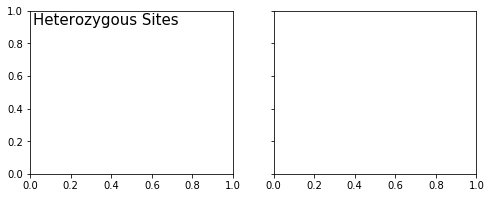

In [85]:
plot_precision_recall('../plots/sequencing_method_het.eps',
                      [#ihart_precision_recall, 
                          #ssc_precision_recall,
                          spark_exome_EX_precision_recall, 
                          #ihart_chip_precision_recall, 
                          spark_precision_recall],
                      [#ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       #ssc_samples.is_child, 
                          spark_exome_samples.is_child, 
                      #ihart_samples.is_child & np.array([x in ihart_chip_is_ok_sample for x in ihart_samples.sample_ids]), 
                      spark_samples.is_child],
                      '1',
                      ['ihart', 'ssc', 'spark', 'ihart', 'spark'],
                      ['#4db6ac', '#4db6ac', '#ef6c00', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS', 'WES', 'Array'], legend_colors=['#4db6ac', '#ef6c00', '#ce93d8'])

plot_precision_recall('../plots/sequencing_method_homalt.eps',
                      [#ihart_precision_recall, 
                          #ssc_precision_recall, 
                          spark_exome_EX_precision_recall, 
                          #ihart_chip_precision_recall, 
                          spark_precision_recall],
                      [#ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       #ssc_samples.is_child, 
                          spark_exome_samples.is_child,
                      #ihart_samples.is_child & np.array([x in ihart_chip_is_ok_sample for x in ihart_samples.sample_ids]),
                      spark_samples.is_child],
                      '2',
                      ['ihart', 'ssc', 'spark', 'ihart', 'spark'],
                      ['#4db6ac', '#4db6ac', '#ef6c00', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS in exome', 'WES', 'Array'], legend_colors=['#4db6ac', '#ef6c00', '#ce93d8'])


# Exome distance from target

In [26]:
all_samples = [spark_exome_samples]
all_error_rates = [spark_exome_EX_error_rates]
all_precision_recall = [spark_exome_EX_precision_recall]
for w in [25, 50, 75, 1000]:
    samples = compare_rates.pull_samples('../../PhasingFamilies/split_gen_spark_exome_EX%d' % w, chroms)
    all_samples.append(samples)

    error_rates = compare_rates.pull_error_rates(samples, '../../PhasingFamilies/parameter_estimation/params/spark_exome_EX%d_params.json' % w, gens, obss)
    all_error_rates.append(error_rates)
    
    precision_recall = compare_rates.pull_precision_recall(samples, '../../PhasingFamilies/parameter_estimation/params/spark_exome_EX%d_params.json' % w)
    all_precision_recall.append(precision_recall)
    
    
    


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


['1.00', '1.07', '1.33', '1.76', '1.95']
['1.00', '1.13', '1.11', '1.21', '1.07']
['1.00', '0.94', '1.76', '3.29', '3.88']
['1.00', '1.16', '2.59', '5.74', '7.33']
['1.00', '2.39', '2.19', '2.50', '3.05']
['1.00', '2.69', '6.11', '15.39', '17.21']


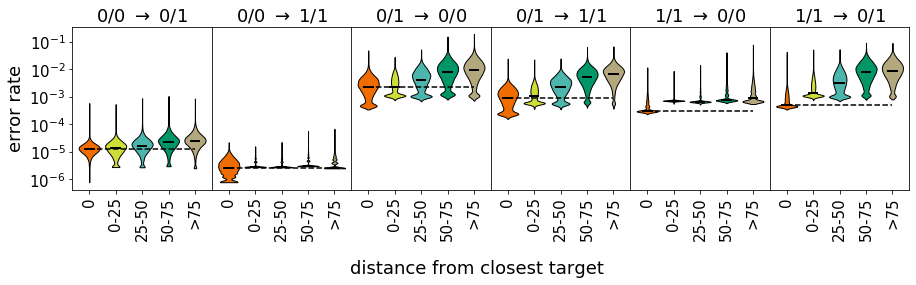

In [27]:

#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
#colors = ['#4db6ac', '#ef6c00', '#695d46', '#a1e8d9', '#ff9800', '#b3a77d', '#009668', '#ce93d8', '#cedd38']
colors = ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ]

errors_of_interest = [('0/0', '0/1'), ('0/0', '1/1'),
                      ('0/1', '0/0'), ('0/1', '1/1'), 
                      ('1/1', '0/0'), ('1/1', '0/1'),
                    #('0/1', './.'), ('1/1', './.')
                            ]
fig, subs = plt.subplots(1, len(errors_of_interest), sharey=True, figsize=(15, 3))
fig.suptitle('distance from closest target', y=-0.2, fontsize=18)



for i, (g, o) in enumerate(errors_of_interest):
    g_index, o_index = gens.index(g), obss.index(o) 
    
    to_plot = []
    for samples, error_rates in zip(all_samples, all_error_rates):
        add_plot = -error_rates[samples.is_child, g_index, o_index]
        add_plot = add_plot[~np.isnan(add_plot)]
        to_plot.append(add_plot)
             
    parts = subs[i].violinplot(to_plot,
               showmedians=True, showextrema=False, widths=0.8)
    
    for pc, color in zip(parts['bodies'], colors):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
        
    #subs[i].plot(range(1, 5), [np.median(x) for x in to_plot], color='black')
    subs[i].plot(range(1, 6), [np.median(to_plot[0])]*5, color='black', linestyle='--')
    print(['%0.2f' % 10.0**(np.median(x)-np.median(to_plot[0])) for x in to_plot])
    
    if i == 0:
        subs[i].set_ylabel('error rate', fontsize=18)
        #subs[i].set_ylim([-7, 1])
        subs[i].set_yticks(np.arange(-6, 1))
        subs[i].set_yticklabels(['$10^{%0.0f}$' % f for f in subs[i].get_yticks()], {'fontsize': 15})
    else:
        subs[i].tick_params('y', length=0)
    subs[i].set_title(r'%s $\rightarrow$ %s' % (g, ' ./.  ' if o=='./.' else o), {'fontsize': 18})
    subs[i].set_xticks(np.arange(1, 6))
    subs[i].set_xticklabels(['0', '0-25', '25-50', '50-75', '>75'], {'fontsize': 15})
    for tick in subs[i].get_xticklabels():
        tick.set_rotation(90)

fig.subplots_adjust(wspace=0.0)


#plt.tight_layout()
#plt.savefig(filename)
plt.show()

n= [9599, 9595, 9599, 9593, 9599]
precision [2.456142136947711e-70, 0.0, 0.0, 0.0]
n= [9599, 9595, 9599, 9593, 9599]
recall [1.3897366304794719e-136, 0.0, 0.0, 0.0]
n= [9599, 9595, 9599, 9593, 9599]
precision [7.406982676136896e-163, 0.0, 0.0, 0.0]
n= [9599, 9595, 9599, 9593, 9599]
recall [0.0, 0.0, 0.0, 0.0]


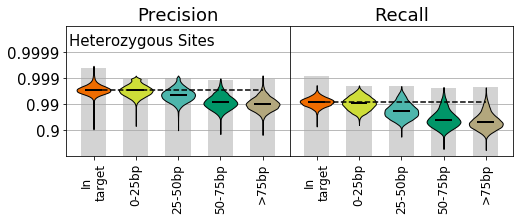

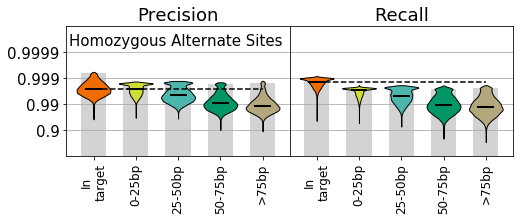

In [28]:
plot_precision_recall('../plots/wes_target_het.eps',
                      all_precision_recall,
                      [samples.is_child for samples in all_samples],
                      '1',
                      ['In\ntarget', '0-25bp', '25-50bp', '50-75bp', '>75bp'],
                      ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ],
                     dotted=True,
                     rotate_xlabels=True, ks_alternative='less')
plot_precision_recall('../plots/wes_target_homalt.eps',
                      all_precision_recall,
                      [samples.is_child for samples in all_samples],
                      '2',
                      ['In\ntarget', '0-25bp', '25-50bp', '50-75bp', '>75bp'],
                      ['#ef6c00', '#cedd38', '#4db6ac', '#009668', '#b3a77d', ],
                     dotted=True,
                     rotate_xlabels=True, ks_alternative='less')


# LCL vs WB

In [29]:
is_lcl = np.zeros((len(ihart_samples.sample_ids),), dtype=bool)
is_wb = np.zeros((len(ihart_samples.sample_ids),), dtype=bool)

with open('../../PhasingFamilies/data/170925.iHART.db.csv', 'r') as f:
    for line in f:
        pieces = line.strip().split(',')
        if pieces[2] in ihart_samples.sample_ids and len(pieces)>25:
            if pieces[25] == 'LCL':
                is_lcl[ihart_samples.sample_ids.index(pieces[2])] = True
            elif pieces[25] == 'WB':
                is_wb[ihart_samples.sample_ids.index(pieces[2])] = True
print('LCL', np.sum(is_lcl), 'WB', np.sum(is_wb))

LCL 3562 WB 489


n= [274, 1963]
precision [8.277449353499833e-06]
n= [274, 1963]
recall [0.013444092370678118]
n= [274, 1963]
precision [0.035575562229711366]
n= [274, 1963]
recall [0.16238520385536093]


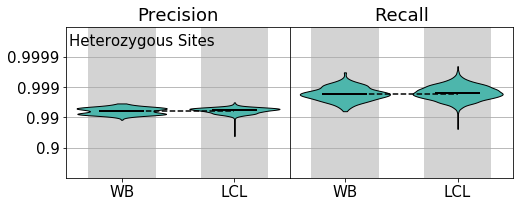

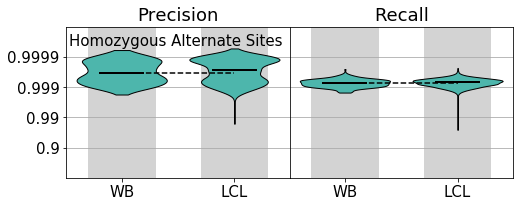

In [30]:
plot_precision_recall('../plots/lcl_wb_het.eps',
                      [ihart_precision_recall, ihart_precision_recall],
                      [ihart_samples.is_child & is_wb & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & is_lcl & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids])],
                      '1',
                      ['WB', 'LCL'],
                      ['#4db6ac', '#4db6ac'],
                     dotted=True)

plot_precision_recall('../plots/lcl_wb_homalt.eps',
                      [ihart_precision_recall, ihart_precision_recall],
                      [ihart_samples.is_child & is_wb & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & is_lcl & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids])],
                      '2',
                      ['WB', 'LCL'],
                      ['#4db6ac', '#4db6ac'],
                     dotted=True)

# GATK Improvement

1.172692878832435 1.1743845688247188
1.0944899076979937 1.1566783889327377


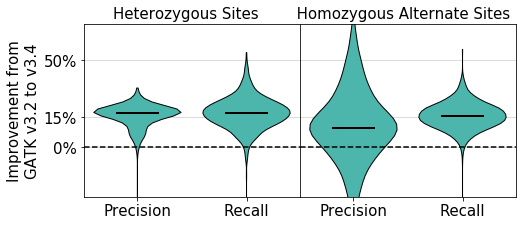

In [31]:
indices = ihart32_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart32_samples.sample_ids])

precision1_delta = -np.log10(1-ihart34_precision_recall.precision1[indices]) + np.log10(1-ihart32_precision_recall.precision1[indices])
precision2_delta = -np.log10(1-ihart34_precision_recall.precision2[indices]) + np.log10(1-ihart32_precision_recall.precision2[indices]) 
recall1_delta = -np.log10(1-ihart34_precision_recall.recall1[indices]) + np.log10(1-ihart32_precision_recall.recall1[indices])
recall2_delta = -np.log10(1-ihart34_precision_recall.recall2[indices]) + np.log10(1-ihart32_precision_recall.recall2[indices]) 

print(10.0**np.nanmedian(precision1_delta), 10.0**np.nanmedian(recall1_delta))
print(10.0**np.nanmedian(precision2_delta), 10.0**np.nanmedian(recall2_delta))

ticks = np.log10([1, 1.15, 1.5])
labels = ['0%', '15%', '50%']


fig = plt.figure(figsize=(8, 3))
fig.suptitle('Heterozygous Sites        Homozygous Alternate Sites', 
             fontsize=15, horizontalalignment='left', x=0.2)

ax = plt.subplot(1, 2, 1)
parts = plt.violinplot([remove_nans(precision1_delta), remove_nans(recall1_delta)], 
                                   showmedians=True, showextrema=False, widths=0.8)
        
        
for pc in parts['bodies']:
    pc.set_facecolor('#4db6ac')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.axhline(0, color='black', linestyle='--')

plt.grid(True, axis='y', color='lightgray')
ax.set_axisbelow(True)

plt.ylim([-0.1, 0.25])
plt.yticks(ticks, labels, fontsize=15)
plt.ylabel('Improvement from\nGATK v3.2 to v3.4', fontsize=15)

plt.xticks(range(1, 3), ['Precision', 'Recall'], fontsize=15)

ax2 = plt.subplot(1, 2, 2, sharey=ax)
parts = plt.violinplot([remove_nans(precision2_delta), remove_nans(recall2_delta)], 
                                   showmedians=True, showextrema=False, widths=0.8)
        
        
for pc in parts['bodies']:
    pc.set_facecolor('#4db6ac')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.axhline(0, color='black', linestyle='--')

plt.grid(True, axis='y', color='lightgray')
ax2.set_axisbelow(True)

plt.tick_params('y', length=0)
plt.xticks(range(1, 3), ['Precision', 'Recall'], fontsize=15)
plt.setp(ax2.get_yticklabels(), visible=False)
fig.subplots_adjust(wspace=0.0, top=0.9, bottom=0.1)

plt.xticks(range(1, 3), ['Precision', 'Recall'], fontsize=15)

fig.subplots_adjust(wspace=0.0, top=0.9, bottom=0.1, left=0.15)

#plt.savefig('../plots/gatk.eps')

# Human reference improvement

In [33]:
id_map = dict()
with open('../../PhasingFamilies/data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        id_map[pieces[1]] = pieces[0]

In [35]:
precision_recall_hg38 = np.zeros((len(ssc_samples.sample_ids), 4))
precision_recall_hg38[:] = np.nan

for x in [1, 2, 3, 4, 5, 7]:
    ssc_phase1_samples = compare_rates.pull_samples('../../PhasingFamilies/split_gen_ssc_phase1/split_gen_ssc_phase1_%d' % x, chroms)
    ssc_phase1_pr = compare_rates.pull_precision_recall(ssc_phase1_samples, '../../PhasingFamilies/parameter_estimation/params/ssc_phase1_%d_params.json' % x)
    for i, sample_id in enumerate(ssc_samples.sample_ids):
        if sample_id in id_map and id_map[sample_id] in ssc_phase1_samples.sample_ids:
            j = ssc_phase1_samples.sample_ids.index(id_map[sample_id])
            precision_recall_hg38[i, 0] = ssc_phase1_pr.precision1[j]
            precision_recall_hg38[i, 1] = ssc_phase1_pr.precision2[j]
            precision_recall_hg38[i, 2] = ssc_phase1_pr.recall1[j]
            precision_recall_hg38[i, 3] = ssc_phase1_pr.recall2[j]

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
Removing 0 individuals involved in multiple generations
Removing 0 individuals missing chromosomal data


1.3129976806095969 0.9906871367740461
0.5996168455370766 1.176606834667582


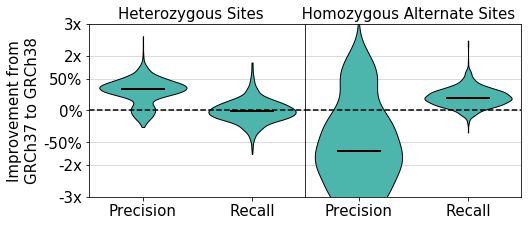

In [36]:
indices = ssc_samples.is_child

precision1_delta = -np.log10(1-precision_recall_hg38[indices, 0]) + np.log10(1-ssc_precision_recall.precision1[indices])
precision2_delta = -np.log10(1-precision_recall_hg38[indices, 1]) + np.log10(1-ssc_precision_recall.precision2[indices]) 
recall1_delta = -np.log10(1-precision_recall_hg38[indices, 2]) + np.log10(1-ssc_precision_recall.recall1[indices])
recall2_delta = -np.log10(1-precision_recall_hg38[indices, 3]) + np.log10(1-ssc_precision_recall.recall2[indices]) 

ticks = np.log10([1/3, 1/2, 1/1.5, 1, 1.5, 2.0, 3.0])
labels = ['-3x', '-2x', '-50%', '0%', '50%', '2x', '3x']

print(10.0**np.nanmedian(precision1_delta), 10.0**np.nanmedian(recall1_delta))
print(10.0**np.nanmedian(precision2_delta), 10.0**np.nanmedian(recall2_delta))

fig = plt.figure(figsize=(8, 3))
fig.suptitle('Heterozygous Sites        Homozygous Alternate Sites', 
             fontsize=15, horizontalalignment='left', x=0.2)

ax = plt.subplot(1, 2, 1)
parts = plt.violinplot([remove_nans(precision1_delta), remove_nans(recall1_delta)], 
                                   showmedians=True, showextrema=False, widths=0.8)
        
        
for pc in parts['bodies']:
    pc.set_facecolor('#4db6ac')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.axhline(0, color='black', linestyle='--')

plt.ylim([-0.1, 0.25])
plt.yticks(ticks, labels, fontsize=15)
plt.grid(True, axis='y', color='lightgray')
ax.set_axisbelow(True)
plt.ylabel('Improvement from\nGRCh37 to GRCh38', fontsize=15)

plt.xticks(range(1, 3), ['Precision', 'Recall'], fontsize=15)

ax2 = plt.subplot(1, 2, 2, sharey=ax)

parts = plt.violinplot([remove_nans(precision2_delta), remove_nans(recall2_delta)], 
                                   showmedians=True, showextrema=False, widths=0.8)
        
        
for pc in parts['bodies']:
    pc.set_facecolor('#4db6ac')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_edgecolor('black')
parts['cmedians'].set_linewidth(2)

plt.axhline(0, color='black', linestyle='--')

plt.grid(True, axis='y', color='lightgray')
ax2.set_axisbelow(True)

plt.ylim([np.log10(1/3), np.log10(3)])
plt.tick_params('y', length=0)
plt.xticks(range(1, 3), ['Precision', 'Recall'], fontsize=15)
plt.setp(ax2.get_yticklabels(), visible=False)
fig.subplots_adjust(wspace=0.0, top=0.9, bottom=0.1, left=0.15)

#plt.savefig('../plots/reference.eps')

In [37]:
def plot_precision_recall_delta(filename, prs, indices, gen, labels, colors, ylim=[0, 5], 
                          rotate_xlabels=False, legend_labels=None, legend_colors=None, ks_alternative='two-sided'):
    fig, subs = plt.subplots(1, 2, sharey=True, figsize=(8, 3))
    
    if gen == '1':  
        fig.suptitle('Heterozygous Sites', fontsize=15, horizontalalignment='left', y=0.87, x=0.13, )
    else:
        fig.suptitle('Homozygous Alternate Sites', fontsize=15, horizontalalignment='left', y=0.87, x=0.13)
    
    for k, attr in enumerate(['precision', 'recall']):
        
        data = [remove_nans(getattr(pr, attr + gen)[ind]) for (pr, ind) in zip(prs, indices)]
        print('n=', [d.shape[0] for d in data])
        parts = subs[k].violinplot(data, showmedians=True, showextrema=False, widths=0.8)


        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_alpha(1)
        parts['cmedians'].set_edgecolor('black')
        parts['cmedians'].set_linewidth(2)

        subs[k].axhline(0, color='black', linestyle='--')

        if k == 0:
            subs[k].set_yticks(np.log10([1/1.5, 1, 1.15, 1.5, 2.0, 3.0]))
            subs[k].set_yticklabels(['-50%', '0%', '15%', '50%', '2x', '3x'], {'fontsize': 15})
        else:
            subs[k].tick_params('y', length=0)
        subs[k].set_title(['Precision', 'Recall'][k], {'fontsize': 18})
        subs[k].set_xticks(np.arange(1, 1+len(prs)))
        subs[k].set_xticklabels(labels, {'fontsize': 12 if rotate_xlabels else 15})
        subs[k].grid(True, axis='y', color='darkgray')
        subs[k].set_axisbelow(True)
        subs[k].set_ylim(ylim)
        if rotate_xlabels:
            for tick in subs[k].get_xticklabels():
                tick.set_rotation(90)

        # legend
        if k == 1 and legend_labels is not None:
            entries = []
            for label, color in zip(legend_labels, legend_colors):
                entries.append(patches.Patch(color=color, label=label))
            subs[k].legend(handles=entries, loc='lower center', ncol=3,
                            bbox_to_anchor=(0, -0.3), borderaxespad=0., fontsize=15, frameon=False)

        print(attr, 
                [scipy.stats.ks_2samp(getattr(prs[0], attr + gen)[indices[0]], getattr(prs[i], attr + gen)[indices[i]], alternative=ks_alternative)[1] for i in range(1, len(labels))])

    fig.subplots_adjust(wspace=0.0, top=0.9, bottom=0.3 if rotate_xlabels else 0.2)
    #plt.show()
    plt.savefig(filename)

n= [1169, 957]
precision [2.220446049250313e-16]
n= [1169, 957]
recall [2.220446049250313e-16]
n= [1169, 957]
precision [2.220446049250313e-16]
n= [1169, 957]
recall [2.220446049250313e-16]


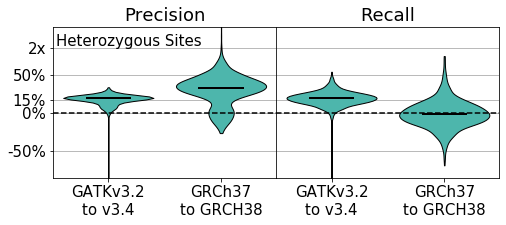

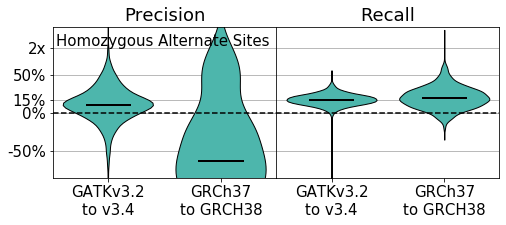

In [38]:
PrecisionRecallDelta = namedtuple('PrecisionRecall', ['precision1', 'recall1', 'precision2', 'recall2',
                    'precision1_upper_bound', 'recall1_upper_bound', 'precision2_upper_bound', 'recall2_upper_bound'])

precision1_delta = -np.log10(1-ihart34_precision_recall.precision1) + np.log10(1-ihart32_precision_recall.precision1)
precision2_delta = -np.log10(1-ihart34_precision_recall.precision2) + np.log10(1-ihart32_precision_recall.precision2) 
recall1_delta = -np.log10(1-ihart34_precision_recall.recall1) + np.log10(1-ihart32_precision_recall.recall1)
recall2_delta = -np.log10(1-ihart34_precision_recall.recall2) + np.log10(1-ihart32_precision_recall.recall2) 
gatk_pr = PrecisionRecallDelta(precision1_delta, recall1_delta, precision2_delta, recall2_delta,
                         None, None, None, None)


precision1_delta = -np.log10(1-precision_recall_hg38[:, 0]) + np.log10(1-ssc_precision_recall.precision1)
precision2_delta = -np.log10(1-precision_recall_hg38[:, 1]) + np.log10(1-ssc_precision_recall.precision2) 
recall1_delta = -np.log10(1-precision_recall_hg38[:, 2]) + np.log10(1-ssc_precision_recall.recall1)
recall2_delta = -np.log10(1-precision_recall_hg38[:, 3]) + np.log10(1-ssc_precision_recall.recall2) 

reference_pr = PrecisionRecallDelta(precision1_delta, recall1_delta, precision2_delta, recall2_delta,
                         None, None, None, None)

plot_precision_recall_delta('../plots/pipeline_het.eps',
                      [gatk_pr, reference_pr],
                      [ihart32_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart32_samples.sample_ids]),
                       ssc_samples.is_child],
                      '1',
                      ['GATKv3.2\nto v3.4', 'GRCh37\nto GRCH38'],
                      ['#4db6ac', '#4db6ac'],
                      ylim=[np.log10(1/2), np.log10(2.5)])

plot_precision_recall_delta('../plots/pipeline_homalt.eps',
                      [gatk_pr, reference_pr],
                      [ihart32_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart32_samples.sample_ids]),
                       ssc_samples.is_child],
                      '2',
                      ['GATKv3.2\nto v3.4', 'GRCh37\nto GRCH38'],
                      ['#4db6ac', '#4db6ac'],
                      ylim=[np.log10(1/2), np.log10(2.5)])


# Look at MSSNG

n= [1127, 1127]
precision [0.0]
n= [1127, 1127]
recall [0.0]
n= [1127, 1127]
precision [4.443848883358921e-173]
n= [1127, 1127]
recall [0.0]


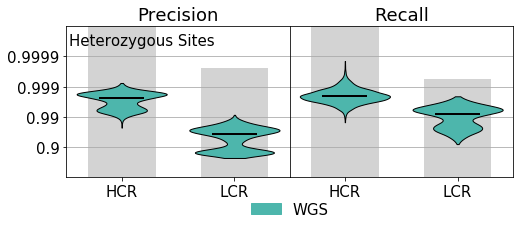

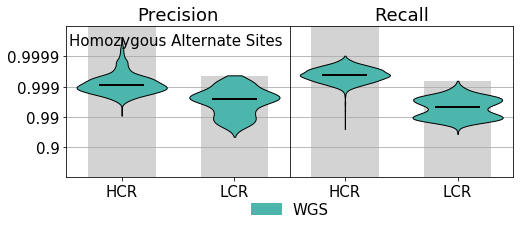

In [71]:
plot_precision_recall('../plots/sequencing_method_het.eps',
                      [mssng_HCR_precision_recall, mssng_LCR_precision_recall],
                      [mssng_samples.is_child, mssng_samples.is_child],
                      '1',
                      ['HCR', 'LCR'],
                      ['#4db6ac', '#4db6ac', '#ef6c00', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS'], legend_colors=['#4db6ac'])

plot_precision_recall('../plots/sequencing_method_homalt.eps',
                      [mssng_HCR_precision_recall, mssng_LCR_precision_recall],
                      [mssng_samples.is_child, mssng_samples.is_child],
                      '2',
                      ['HCR', 'LCR'],
                      ['#4db6ac', '#4db6ac', '#ef6c00', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS'], legend_colors=['#4db6ac'])


# Look at LCR vs CEN and TEL

n= [0, 0, 0, 0]


ValueError: zero-size array to reduction operation minimum which has no identity

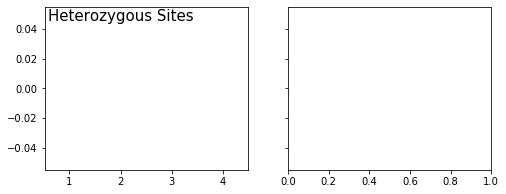

In [56]:
plot_precision_recall('../plots/sequencing_method_het.eps',
                      [ihart_HCR_precision_recall, ihart_LCR_precision_recall, ihart_CEN_precision_recall, ihart_TEL_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]),
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids])],
                      '1',
                      ['HCR', 'LCR', 'CEN', 'TEL'],
                      ['#4db6ac', '#4db6ac', '#ef6c00', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS'], legend_colors=['#4db6ac'])

plot_precision_recall('../plots/sequencing_method_homalt.eps',
                      [ihart_HCR_precision_recall, ihart_LCR_precision_recall, 
                       ihart_CEN_precision_recall, ihart_TEL_precision_recall],
                      [ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]), 
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids]),
                       ihart_samples.is_child & np.array([x in ihart_is_ok_sample for x in ihart_samples.sample_ids])],
                      '2',
                      ['HCR', 'LCR', 'CEN', 'TEL'],
                      ['#4db6ac', '#4db6ac', '#ef6c00', '#ce93d8', '#ce93d8'],
                      legend_labels=['WGS'], legend_colors=['#4db6ac'])
